<a href="https://colab.research.google.com/github/LollaGavrishko/ML/blob/main/kaggle_mnist_CNN_competition_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Соревнования по распознаванию рукописных цифр на Kaggle
Источник:
Соревнования на Kaggle по распознаванию рукописных цифр | Нейросети в Google Colab

https://www.youtube.com/watch?v=zO0RAtZRkpc&feature=youtu.be

Пример кода для отправки решения на соревнование Kaggle - https://www.kaggle.com/c/digit-recognizer

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np # linear algebra
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Настраиваем Kaggle API

Загружаем токен аутентификации

In [ ]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!ls

kaggle.json  sample_data


Копируем токен в каталог .kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

## Загружаем данные с сайта Kaggle

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 179MB/s]


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Гавришко Л.А./train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Гавришко Л.А./test.csv')

In [ ]:
!ls

digit-recognizer.zip  drive  sample_data


In [ ]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
!unzip train.csv.zip

unzip:  cannot find or open train.csv.zip, train.csv.zip.zip or train.csv.zip.ZIP.


##Смотрим на формат данных

Данные для обучения

In [ ]:
!head train_data

head: cannot open 'train_data' for reading: No such file or directory


Данные для тестирования

In [ ]:
!head test.csv

head: cannot open 'test.csv' for reading: No such file or directory


Пример файла с решением

In [ ]:
!head sample_submission.csv

head: cannot open 'sample_submission.csv' for reading: No such file or directory


## Подготовка данных для обучения сети

Загружаем данные для обучения из файла

In [ ]:
train_dataset = np.loadtxt('/content/drive/MyDrive/Гавришко Л.А./train.csv', skiprows=1, delimiter=',')

In [ ]:
train_dataset[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Выделяем данные для обучения

In [ ]:
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
# форма данных обучающего набора
x_train.shape

(42000, 28, 28, 1)

Нормализуем данные для обучения

In [ ]:
x_train /= 255.0

In [ ]:
# форма одного изображения из обучающего набора
x_train[1].shape

(28, 28, 1)

Выделяем правильные ответы

In [ ]:
y_train = train_dataset[:, 0]

In [ ]:
y_train[:5]

array([1., 0., 1., 4., 0.])

Преобразуем ответы в формат one hot encoding

In [ ]:
y_train = utils.to_categorical(y_train)

In [ ]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Разделяем набор данных на две части: для обучения (X_Train, Y_train) и проверки (X_val, Y_val)

In [ ]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
# форма данных обучающего набора
X_train.shape

(37800, 28, 28, 1)

In [ ]:
X_val.shape

(4200, 28, 28, 1)

In [ ]:
Y_train.shape

(37800, 10)

In [ ]:
Y_val.shape

(4200, 10)

#Создаем генератор для расширения данных во время обучения
Расширение данных реализуется  в процессе обучения за счет трансформации имеющихся данных.

Для этого при обучении модели используется метод flow, который применяется к данным в datagen, которые, в свою очередь, мы пропускаем через генератор ImageDataGenerator.
Это так называемое "обучение на лету".

В итоге во время обучения  сеть каждый раз видит разные изображения, трансформированные случайным образом из исходных изображений за счет применения ImageDataGenerator. За счет этого и достигается расширение данных.

Подробнее: см. Франсуа Шолле, 5.2. Расширение данных, с. 169

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)

In [ ]:
# сохраним в переменную data изображение из обучающего набора X_train
data = X_train[1]

In [ ]:
data.shape

(28, 28, 1)

In [ ]:
# изменение формы - добавим ось на первую позицию для отображения количества изображений
data = np.expand_dims(data, axis=0)

In [ ]:
data.shape

(1, 28, 28, 1)

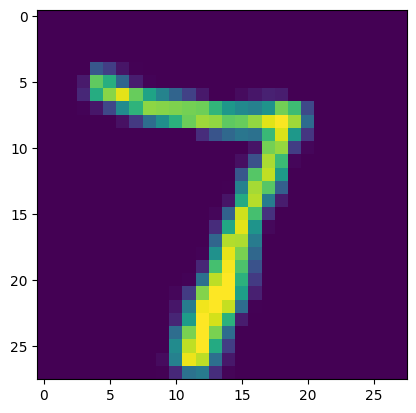

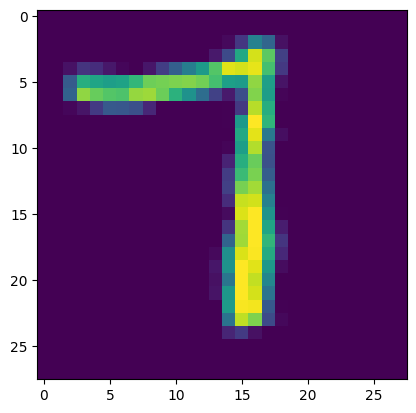

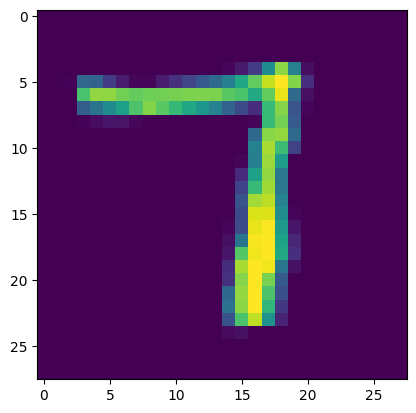

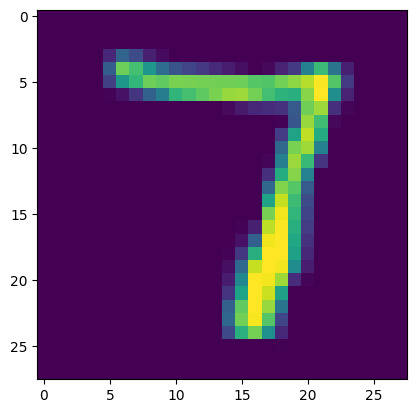

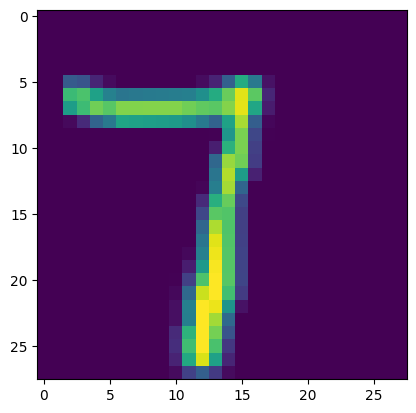

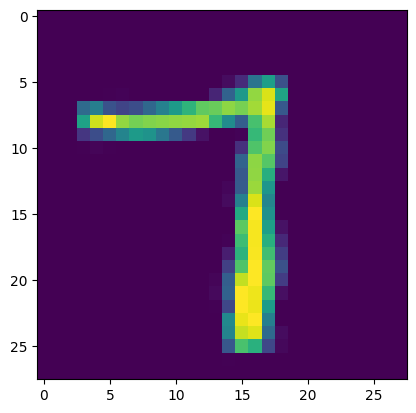

In [ ]:
# продемонстрируем работу ImageDataGenerator на примере одного изображения
i = 0
#data = X_train[0]
#data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Создаем нейронную сеть

**Создаем последовательную модель**

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

**Компилируем сеть**

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

## Обучаем нейронную сеть

In [ ]:
сheckpoint = ModelCheckpoint('mnist-cnn.h5',
                              monitor='val_accuracy',
                              save_best_only=True,
                              verbose=1)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
batch_size=96

In [ ]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
393/393 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8629
Epoch 1: val_accuracy improved from -inf to 0.97952, saving model to mnist-cnn.h5
393/393 [==============================] - 270s 684ms/step - loss: 0.4286 - accuracy: 0.8629 - val_loss: 0.0634 - val_accuracy: 0.9795 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
393/393 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9598
Epoch 2: val_accuracy improved from 0.97952 to 0.98357, saving model to mnist-cnn.h5
393/393 [==============================] - 270s 687ms/step - loss: 0.1367 - accuracy: 0.9598 - val_loss: 0.0493 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/30
393/393 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9700
Epoch 3: val_accuracy improved from 0.98357 to 0.98690, saving model to mnist-cnn.h5
393/393 [==============================] - 267s 679ms/step - loss: 0.1023 - accuracy: 0.9700 - val_loss: 0.0421 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 4/30
393/393 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9753
Epoch 4: val_accuracy improved from 0.98690 to 0.99095, saving model to mnist-cnn.h5
393/393 [==============================] - 267s 677ms/step - loss: 0.0829 - accuracy: 0.9753 - val_loss: 0.0310 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 5/30
39

In [ ]:
model.load_weights('mnist-cnn.h5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history.history['val_accuracy']

[0.9833333492279053,
 0.9859523773193359,
 0.991190493106842,
 0.9904761910438538,
 0.9930952191352844,
 0.9928571581840515,
 0.9928571581840515,
 0.993571400642395,
 0.9933333396911621,
 0.9916666746139526,
 0.994523823261261,
 0.9926190376281738,
 0.9940476417541504,
 0.9938095211982727,
 0.9942857027053833,
 0.9957143068313599,
 0.9950000047683716,
 0.994523823261261,
 0.9928571581840515,
 0.9957143068313599,
 0.9959523677825928,
 0.9950000047683716,
 0.9950000047683716,
 0.9950000047683716,
 0.9952380657196045,
 0.9954761862754822,
 0.9959523677825928,
 0.9961904883384705,
 0.9959523677825928,
 0.9959523677825928]

In [ ]:
max(history.history['val_accuracy'])

0.9961904883384705

## Визуализация качества обучения


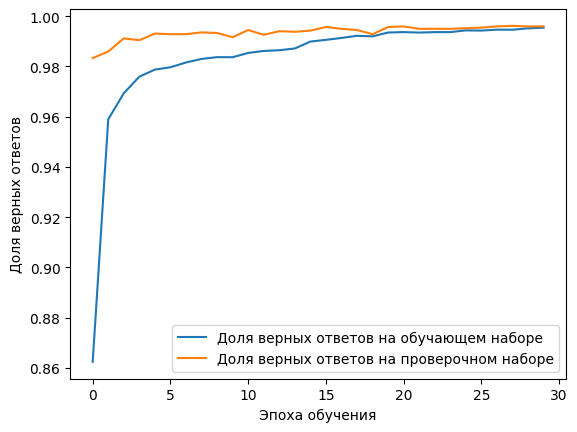

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем данные для распознавания

In [ ]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [ ]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

Нормализация данных

In [ ]:
x_test = x_test / 255.0

## Запускаем распознавание рукописных цифр из тестового набора данных

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[:3]

array([[1.4126280e-14, 1.4342450e-13, 9.9999994e-01, 6.2703103e-13,
        1.5528280e-13, 3.5205580e-18, 2.1858071e-17, 3.3104938e-12,
        3.4031252e-13, 2.1602047e-14],
       [9.9999982e-01, 1.2101909e-12, 4.7279247e-10, 6.3209503e-12,
        4.8939828e-12, 8.6059421e-10, 1.5783446e-08, 1.8012837e-10,
        1.0931388e-09, 8.0105899e-08],
       [4.1459778e-08, 7.3876566e-10, 2.7408573e-06, 6.4844698e-08,
        8.9569348e-06, 1.8706052e-10, 8.8009886e-12, 4.2152030e-07,
        2.2847319e-06, 9.9998540e-01]], dtype=float32)

Преобразуем результаты распознавания из формата one hot encoding в цифры

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions[:3]

array([2, 0, 9])

### Готовим файл с решением для Kaggle

In [ ]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [ ]:
out[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

Записываем результаты в файл

In [ ]:
np.savetxt('submission.csv', out, header="ImageId,Label",
            comments="", fmt="%d,%d")

In [ ]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


## Отправляем решение на соревнование

In [ ]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

# ***Рекомендуем почитать
Как правильно «фармить» Kaggle
https://habr.com/ru/company/ods/blog/426227/
